## Modelagem - Predição da produtividade da cana-de-açúcar

Nesta série de scripts iremos começar o processo de modelagem. O método que mais se aplica ao nosso conjunto de dados é a análise de dados em painel, que é um tipo de regressão linear, que considera os efeitos dos indivíduos e do tempo, na forma de séries temporais. Aqui iremos aplicar a análise em painel primeiro. Usei o exemplo desse [link](https://bashtage.github.io/linearmodels/panel/examples/examples.html).

Seguidamente, também utilizaremos machine learning. Aqui eu testei o gradient boosting e random forest. Fiz uma grid search básico para procurar os melhores parametros do modelo e escolhi o gradient boosting para continuar. Para este modelo, também utilizei o Shapley values (teoria de jogos) para entender quais variavéis foram mais importantes para explicar a produtividade da cana-de-açúcar. 

Links:
1. [A Guide to Panel Data Regression: Theoretics and Implementation with Python](https://towardsdatascience.com/a-guide-to-panel-data-regression-theoretics-and-implementation-with-python-4c84c5055cf8)

### Parte 1: Panel data

#### 1.1. Todos os municípios

In [1]:
# Carregar librarias
import pandas as pd
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy import stats
from pprint import pprint
from sklearn import metrics
from linearmodels import PanelOLS
from sklearn.metrics import mean_squared_error, r2_score
from linearmodels.panel import PooledOLS, RandomEffects, BetweenOLS, compare
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Carregar dataset dos anos 2000-2014
data_sugarcane = pd.read_csv("tables/new_data_all_2000-2014.csv", sep =  ';').drop(['AP'], axis = 1)

In [ ]:
Treinamento: 2000-2014
Teste: 2015-2020

In [3]:
# Visão dos dados
data_sugarcane.head()

,CD_MUN,MUN,Year,Yield,AC,QP,VP,AET,NDVI,NPP,SOIL,TMIN,TMMX,PR,LST
0,3500105,Adamantina (SP),2000,50000.0,7000.0,350000.0,6244.0,704,5174.465583,4047,165.814275,163,288,91,15244
1,3500204,Adolfo (SP),2000,NaN,NaN,NaN,NaN,716,4079.833442,5245,255.016962,162,290,94,15090
2,3500303,Aguaí (SP),2000,80000.0,5250.0,420000.0,7493.0,675,5613.906725,8672,398.974009,151,272,109,15133
3,3500550,Águas de Santa Bárbara (SP),2000,NaN,NaN,NaN,NaN,776,5388.291761,8146,245.525207,142,270,95,15148
4,3500709,Agudos (SP),2000,70000.0,8000.0,560000.0,9990.0,746,5968.640067,9080,247.830150,146,274,94,15097


In [56]:
# Converter o ano para categórico
year_sugar = pd.Categorical(data_sugarcane.Year)

In [57]:
# Criar o index utilizando o ano e o código do municipio
data_sugar = data_sugarcane.set_index(['CD_MUN', 'Year'])
data_sugar['Year'] = year_sugar
data_sugar

,,MUN,Yield,AC,QP,VP,AET,NDVI,NPP,SOIL,TMIN,TMMX,PR,LST,Year
CD_MUN,Year,,,,,,,,,,,,,,
3500105,2000,Adamantina (SP),50000.0,7000.0,350000.0,6244.0,704,5174.465583,4047,165.814275,163,288,91,15244,2000
3500204,2000,Adolfo (SP),NaN,NaN,NaN,NaN,716,4079.833442,5245,255.016962,162,290,94,15090,2000
3500303,2000,Aguaí (SP),80000.0,5250.0,420000.0,7493.0,675,5613.906725,8672,398.974009,151,272,109,15133,2000
3500550,2000,Águas de Santa Bárbara (SP),NaN,NaN,NaN,NaN,776,5388.291761,8146,245.525207,142,270,95,15148,2000
3500709,2000,Agudos (SP),70000.0,8000.0,560000.0,9990.0,746,5968.640067,9080,247.830150,146,274,94,15097,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3556958,2014,Vitória Brasil (SP),90000.0,450.0,40500.0,2105.0,715,5585.656276,6418,333.110063,166,294,91,15321,2014
3557105,2014,Votuporanga (SP),70000.0,8387.0,587090.0,36987.0,739,5642.405411,6471,318.736667,170,299,95,15278,2014
3557154,2014,Zacarias (SP),70000.0,8238.0,576660.0,28412.0,729,4936.442236,6392,275.759016,167,295,90,15127,2014


In [58]:
# Info
data_sugar.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7275 entries, (3500105, 2000) to (3557303, 2014)
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   MUN     7275 non-null   object  
 1   Yield   6653 non-null   float64 
 2   AC      6655 non-null   float64 
 3   QP      6655 non-null   float64 
 4   VP      6655 non-null   float64 
 5   AET     7275 non-null   int64   
 6   NDVI    7275 non-null   float64 
 7   NPP     7275 non-null   int64   
 8   SOIL    7275 non-null   float64 
 9   TMIN    7275 non-null   int64   
 10  TMMX    7275 non-null   int64   
 11  PR      7275 non-null   int64   
 12  LST     7275 non-null   int64   
 13  Year    7275 non-null   category
dtypes: category(1), float64(6), int64(6), object(1)
memory usage: 788.7+ KB


In [90]:
# Selecionar as variáveis que serão utilizadas na modelagem
exog_vars_sugar = ['AC', 'QP', 'VP', 'AET', 'NDVI', 'SOIL', 'TMIN', 'TMMX', 'PR', 'LST']

In [91]:
# Adicionar a constante
exog_sugar = sm.add_constant(data_sugar[exog_vars_sugar])
exog_sugar.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7275 entries, (3500105, 2000) to (3557303, 2014)
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   const   7275 non-null   float64
 1   AC      6655 non-null   float64
 2   QP      6655 non-null   float64
 3   VP      6655 non-null   float64
 4   AET     7275 non-null   int64  
 5   NDVI    7275 non-null   float64
 6   SOIL    7275 non-null   float64
 7   TMIN    7275 non-null   int64  
 8   TMMX    7275 non-null   int64  
 9   PR      7275 non-null   int64  
 10  LST     7275 non-null   int64  
dtypes: float64(6), int64(5)
memory usage: 667.2 KB


In [92]:
# Criar e rodar o modelo  - Fixed effects
mod_fixed_sugar = PanelOLS(data_sugar.Yield, exog_sugar) 
fe_res_sugar = mod_fixed_sugar.fit()
print(fe_res_sugar)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  Yield   R-squared:                        0.3335
Estimator:                   PanelOLS   R-squared (Between):              0.3916
No. Observations:                6653   R-squared (Within):               0.2925
Date:                Sun, Oct 16 2022   R-squared (Overall):              0.3335
Time:                        11:16:38   Log-likelihood                -7.149e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      332.29
Entities:                         485   P-value                           0.0000
Avg Obs:                       13.718   Distribution:                 F(10,6642)
Min Obs:                       7.0000                                           
Max Obs:                       15.000   F-statistic (robust):             332.29
                            

In [93]:
# Criar e rodar o modelo  - Random effects
mod_random_sugar = RandomEffects(data_sugar.Yield, exog_sugar)
re_res_sugar = mod_random_sugar.fit()
print(re_res_sugar)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  Yield   R-squared:                        0.3408
Estimator:              RandomEffects   R-squared (Between):              0.3193
No. Observations:                6653   R-squared (Within):               0.3079
Date:                Sun, Oct 16 2022   R-squared (Overall):              0.3158
Time:                        11:16:42   Log-likelihood                -7.027e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      343.32
Entities:                         485   P-value                           0.0000
Avg Obs:                       13.718   Distribution:                 F(10,6642)
Min Obs:                       7.0000                                           
Max Obs:                       15.000   F-statistic (robust):             296.96
                            

In [94]:
# Haussman
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b-B).T, la.inv(v_b-v_B).dot(b-B)) 
    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

hausman_results = hausman(fe_res_sugar, re_res_sugar) 
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: -157.6500149786556
degrees of freedom: 11
p-Value: 1.0



H0: p-value > 0.05  -- Random Effects  
H1: p-value < 0.05

Como o valor de p é alto, a hipótese nula pode ser aceita. Assim, o modelo RE parece ser o mais adequado.  

O teste de Hausman às vezes é descrito como um teste para especificação incorreta do modelo. Na análise de dados em painel (a análise dos dados ao longo do tempo), o teste de Hausman pode ajudá-lo a escolher entre um modelo de efeitos fixos ou um modelo de efeitos aleatórios. A hipótese nula é que o modelo preferido é o de efeitos aleatórios; a hipótese alternativa é que o modelo é de efeitos fixos. Essencialmente, os testes procuram ver se existe uma correlação entre os erros únicos e os regressores no modelo. A hipótese nula é que não há correlação entre os dois.

Efeitos fixos são variáveis que são constantes entre os indivíduos; essas variáveis, como idade, sexo ou etnia, não mudam ou mudam a uma taxa constante ao longo do tempo. Eles têm efeitos fixos; em outras palavras, qualquer mudança que causem a um indivíduo é a mesma. Por exemplo, quaisquer efeitos de ser uma mulher, uma pessoa de cor ou um jovem de 17 anos não mudarão com o tempo.

O oposto de efeitos fixos são efeitos aleatórios. Essas variáveis são — como o nome sugere — aleatórias e imprevisíveis; são literalmente efeitos aleatórios.

Exemplos:
- O preço de um jantar de três pratos varia muito dependendo da localização (por exemplo, Yulee, Flórida, será muito mais barato que a cidade de Nova York).
- O custo de um carro novo varia de acordo com o ano em que foi adquirido (por exemplo, 1941 vs. 2018).

In [64]:
# Carregar os dados preditos para os outros anos
pred_yield = pd.read_csv('predictions/predicted_2014-2020.csv', sep = ';').drop(['ID'], axis = 1)
pred_yield.head()

,CD_MUN,MUN,Year,Yield,Predicted yield
0,3500105,Adamantina (SP),2015,80000.0,77446.25
1,3500204,Adolfo (SP),2015,70000.0,73213.85
2,3500303,Aguaí (SP),2015,80000.0,74468.28
3,3500550,Águas de Santa Bárbara (SP),2015,90000.0,75792.47
4,3500709,Agudos (SP),2015,64794.0,59973.32


In [65]:
# Remover NA
pred_yield.dropna(inplace = True)

In [51]:
# Erro médio e RMSE do conjunto teste
baseline_errors_15_20 = abs(pred_yield['Yield'].mean() - pred_yield['Yield'])
print('Erro médio base: ', round(np.mean(baseline_errors_15_20), 2), 'kg/ha')
rmse_pda = float(format(np.sqrt(mean_squared_error(pred_yield['Yield'], pred_yield['Predicted yield'])), '.2f'))
print('RMSE: ', rmse_pda, 'kg/ha')

Erro médio base:  8093.33 kg/ha
RMSE:  9157.55 kg/ha


In [66]:
# Agrupar por ano e calcular o desvio padrão
pred_by_year = pd.DataFrame(pred_yield.groupby('Year')['Predicted yield'].mean().reset_index())
pred_by_year['Predicted yield'] = pred_by_year['Predicted yield'].astype(int)
st_pred_yield = pd.DataFrame(pred_yield.groupby('Year')['Predicted yield'].std()).reset_index()
st_pred_yield.rename(columns = {'Predicted yield': 'st_pred_yield'}, inplace = True)
st_pred_yield['st_pred_yield'] = st_pred_yield['st_pred_yield'].astype(int)
new_pred_by_year = pred_by_year.join([st_pred_yield['st_pred_yield']])
new_pred_by_year = new_pred_by_year.astype(int)
new_pred_by_year['Year'] = pd.to_datetime(new_pred_by_year['Year'], format = '%Y')
new_pred_by_year

,Year,Predicted yield,st_pred_yield
0,2015-01-01,73555,7567
1,2016-01-01,75828,7363
2,2017-01-01,76388,8605
3,2018-01-01,76591,7653
4,2019-01-01,78032,7359
5,2020-01-01,78805,7221


In [67]:
# Plots
## Carregar os dados de todos os anos
obs_yield = pd.read_csv("tables/dat_yield_melt_all_years.csv").drop(['Unnamed: 0'], axis = 1)
obs_yield.rename(columns = {'variable': 'Year', 'value': 'Yield'}, inplace = True)
new_by_year = pd.DataFrame(obs_yield.groupby('Year')['Yield'].mean().reset_index())
new_by_year['Yield'] = new_by_year['Yield'].astype(int)
st_yield = pd.DataFrame(obs_yield.groupby('Year')['Yield'].std()).reset_index()
st_yield.rename(columns = {'Yield': 'st_yield'}, inplace = True)
st_yield['st_yield'] = st_yield['st_yield'].astype(int)
new_data_by_year = new_by_year.join([st_yield['st_yield']])
new_data_by_year = new_data_by_year.astype(int)
new_data_by_year['Year'] = pd.to_datetime(new_data_by_year['Year'], format = '%Y')
new_data_by_year

,Year,Yield,st_yield
0,2000-01-01,75980,13483
1,2001-01-01,76309,12431
2,2002-01-01,77228,12757
3,2003-01-01,78786,15468
4,2004-01-01,79715,12006
5,2005-01-01,80696,13380
6,2006-01-01,83491,17777
7,2007-01-01,83649,15362
8,2008-01-01,82926,14588
9,2009-01-01,84098,15308


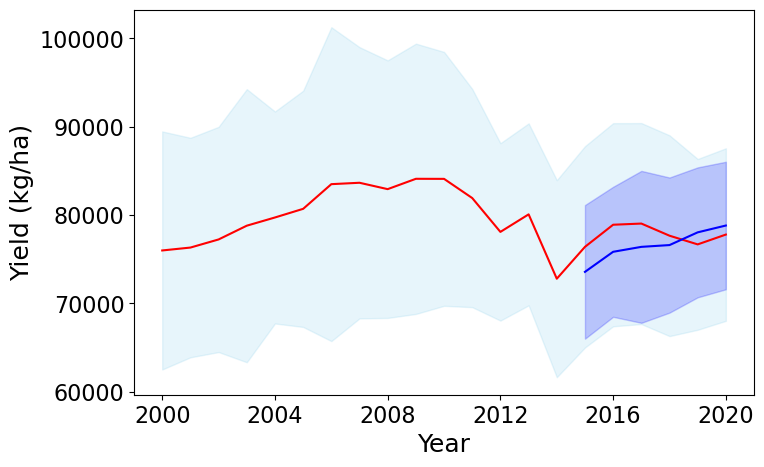

In [68]:
# Plots
plt.figure(figsize = (8,5))
plt.plot(new_data_by_year['Year'], new_data_by_year['Yield'], color = 'red', label='observed')
plt.fill_between(new_data_by_year['Year'], (new_data_by_year['Yield'] + new_data_by_year['st_yield']), 
                 (new_data_by_year['Yield'] - new_data_by_year['st_yield']), alpha = 0.2, color = 'skyblue')
plt.plot(new_pred_by_year['Year'], new_pred_by_year['Predicted yield'], color = 'blue', label = 'predicted')
plt.fill_between(new_pred_by_year['Year'], (new_pred_by_year['Predicted yield'] + new_pred_by_year['st_pred_yield']), 
                (new_pred_by_year['Predicted yield'] - new_pred_by_year['st_pred_yield']), alpha = 0.2, color = 'blue')
plt.ylabel('Yield (kg/ha)', fontsize = 18)
plt.tick_params(labelsize=16)
plt.xlabel('Year', fontsize = 18)
#plt.savefig("predicted_yield_over_time.jpeg", dpi = 300)
plt.show()

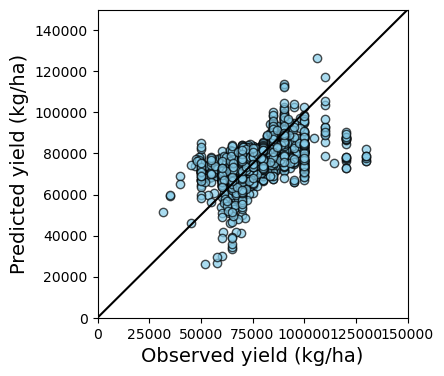

In [69]:
# Plot
fig, ax = plt.subplots(figsize=(4, 4))
ax = plt.gca()
ax.set_ylim([0, 150000])
ax.set_xlim([0, 150000])
ax.scatter(pred_yield['Yield'], pred_yield['Predicted yield'], edgecolor='k', facecolor='skyblue', alpha=0.7)
ax.axline((0, 1), slope=1, color='black', label='by slope')
ax.set_ylabel('Predicted yield (kg/ha)', fontsize=14)
ax.set_xlabel('Observed yield (kg/ha)', fontsize=14)
#plt.savefig('predicted_vs_observed_2015-2020.jpeg', dpi = 300)
plt.show()

#### 1.2. Predição por quantil

In [70]:
# Carregar dataset dos anos 2000-2014 - Quantiles
sugar_quantil = pd.read_csv("tables/new_data_quantiles.csv", sep =  ',').drop(['AP', 'Unnamed: 0'], axis = 1)
sugar_quantil.rename(columns = {'variable': 'Year', 'value':'Yield'}, inplace = True)
sugar_quantil['quantiles_yield']  = sugar_quantil['quantiles_yield'].astype('string')

In [71]:
# Separar os quantis dos anos 2015-2020
sugar_quantil_train = sugar_quantil.iloc[:75]
sugar_quantil_test = sugar_quantil.iloc[76:]
#sugar_quantil_test.to_csv("dat_quantil_2015-2020.csv")

In [72]:
# Converter o ano para categórico
year_sugar = pd.Categorical(sugar_quantil_train.Year)

In [73]:
# Criar o index utilizando o ano e o código do municipio
sugar_quantil_train_new = sugar_quantil_train.set_index(['quantiles_yield', 'Year'])
sugar_quantil_train_new['Year'] = year_sugar
sugar_quantil_train_new

,,Yield,AC,QP,VP,AET,NDVI,NPP,SOIL,TMIN,TMMX,PR,LST,Year
quantiles_yield,Year,,,,,,,,,,,,,
0,2000,65799.0,3554.0,234130.0,4177.0,724,5604,8286,275,150,270,102,15120,2000
1,2000,73683.0,7822.0,560907.0,10007.0,713,5379,6662,249,156,278,101,15181,2000
2,2000,74812.0,7119.0,542044.0,9670.0,713,5309,6687,277,156,279,102,15185,2000
3,2000,80359.0,8446.0,669874.0,11951.0,700,5286,6800,302,158,280,104,15195,2000
4,2000,86921.0,6659.0,556949.0,9936.0,698,5233,6377,271,158,281,101,15205,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2014,67590.0,6881.0,443992.0,23939.0,753,6081,9500,304,156,276,96,15135,2014
1,2014,70124.0,12296.0,857436.0,46478.0,748,5840,7994,272,162,284,95,15194,2014
2,2014,71563.0,13357.0,933422.0,48736.0,746,5770,7917,303,162,285,96,15198,2014


In [84]:
# Selecionar as variáveis que serão utilizadas na modelagem
exog_quantil = ['AC', 'QP', 'VP', 'AET', 'NDVI', 'SOIL', 'TMIN', 'TMMX', 'PR', 'LST']

In [85]:
# Adicionar a constante
exog_quantil = sm.add_constant(sugar_quantil_train_new[exog_quantil])
exog_quantil.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 75 entries, ('0', 2000) to ('4', 2014)
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   const   75 non-null     float64
 1   AC      75 non-null     float64
 2   QP      75 non-null     float64
 3   VP      75 non-null     float64
 4   AET     75 non-null     int64  
 5   NDVI    75 non-null     int64  
 6   SOIL    75 non-null     int64  
 7   TMIN    75 non-null     int64  
 8   TMMX    75 non-null     int64  
 9   PR      75 non-null     int64  
 10  LST     75 non-null     int64  
dtypes: float64(4), int64(7)
memory usage: 7.6+ KB


In [86]:
# Criar e rodar o modelo  - Random effects
random_q = RandomEffects(sugar_quantil_train_new.Yield, exog_quantil).fit()
print(random_q)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  Yield   R-squared:                        0.9028
Estimator:              RandomEffects   R-squared (Between):              0.9761
No. Observations:                  75   R-squared (Within):               0.6140
Date:                Sun, Oct 16 2022   R-squared (Overall):              0.9028
Time:                        11:15:06   Log-likelihood                   -695.72
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      59.427
Entities:                           5   P-value                           0.0000
Avg Obs:                       15.000   Distribution:                   F(10,64)
Min Obs:                       15.000                                           
Max Obs:                       15.000   F-statistic (robust):             59.427
                            

In [87]:
# Carregar os dados preditos para os outros anos
pred_yield_q = pd.read_csv('predictions/predicted_2015-2020_quantiles.csv', sep = ';').drop(['ID'], axis = 1)
pred_yield_q.head()

,quantiles_yield,Year,Yield,AC,QP,VP,AET,NDVI,NPP,SOIL,TMIN,TMMX,PR,LST,Pred_yield
0,1,2015,73000,11860,870471,45957,855,6322,8770,354,163,284,137,15139,68221.6005
1,2,2015,75295,13432,1008805,53045,859,6298,8733,383,162,286,137,15143,66557.2679
2,3,2015,79202,15066,1194047,64608,847,6207,8434,388,164,286,136,15165,69261.2537
3,4,2015,83597,10359,850024,45824,844,6256,8516,370,164,287,133,15159,78652.6558
4,0,2016,70658,6675,472945,30320,809,6103,10779,374,150,271,119,15086,53883.9825


In [88]:
# Erro médio e RMSE do conjunto teste
baseline_errors_15_20_q = abs(pred_yield_q['Yield'].mean() - pred_yield_q['Yield'])
print('Erro médio base: ', round(np.mean(baseline_errors_15_20_q), 2), 'kg/ha')
rmse_pda_q = float(format(np.sqrt(mean_squared_error(pred_yield_q['Yield'], pred_yield_q['Pred_yield'])), '.2f'))
print('RMSE: ', rmse_pda_q, 'kg/ha')

Erro médio base:  4334.17 kg/ha
RMSE:  17020.19 kg/ha


In [89]:
# Agrupar por ano e calcular o desvio padrão
pred_by_year_q = pd.DataFrame(pred_yield_q.groupby('Year')['Pred_yield'].mean().reset_index())
pred_by_year_q['Pred_yield'] = pred_by_year_q['Pred_yield'].astype(int)
st_pred_yield_q = pd.DataFrame(pred_yield_q.groupby('Year')['Pred_yield'].std()).reset_index()
st_pred_yield_q.rename(columns = {'Pred_yield': 'st_pred_yield'}, inplace = True)
st_pred_yield_q['st_pred_yield'] = st_pred_yield_q['st_pred_yield'].astype(int)
new_pred_by_year_q = pred_by_year_q.join([st_pred_yield_q['st_pred_yield']])
new_pred_by_year_q = new_pred_by_year_q.astype(int)
new_pred_by_year_q['Year'] = pd.to_datetime(new_pred_by_year_q['Year'], format = '%Y')
new_pred_by_year_q

,Year,Pred_yield,st_pred_yield
0,2015-01-01,70673,5434
1,2016-01-01,61731,7839
2,2017-01-01,60531,8277
3,2018-01-01,63299,6896
4,2019-01-01,72670,6221
5,2020-01-01,50319,5981


In [80]:
# Plots
## Carregar os dados de todos os anos
obs_yield = pd.read_csv("tables/dat_yield_melt_all_years.csv").drop(['Unnamed: 0'], axis = 1)
obs_yield.rename(columns = {'variable': 'Year', 'value': 'Yield'}, inplace = True)
obs_by_year = pd.DataFrame(obs_yield.groupby('Year')['Yield'].mean().reset_index())
obs_by_year['Yield'] = obs_by_year['Yield'].astype(int)
st_yield_obs = pd.DataFrame(obs_yield.groupby('Year')['Yield'].std()).reset_index()
st_yield_obs.rename(columns = {'Yield': 'st_yield'}, inplace = True)
st_yield_obs['st_yield'] = st_yield_obs['st_yield'].astype(int)
new_data_by_year = obs_by_year.join([st_yield_obs['st_yield']])
new_data_by_year = new_data_by_year.astype(int)
new_data_by_year['Year'] = pd.to_datetime(new_data_by_year['Year'], format = '%Y')
new_data_by_year

,Year,Yield,st_yield
0,2000-01-01,75980,13483
1,2001-01-01,76309,12431
2,2002-01-01,77228,12757
3,2003-01-01,78786,15468
4,2004-01-01,79715,12006
5,2005-01-01,80696,13380
6,2006-01-01,83491,17777
7,2007-01-01,83649,15362
8,2008-01-01,82926,14588
9,2009-01-01,84098,15308


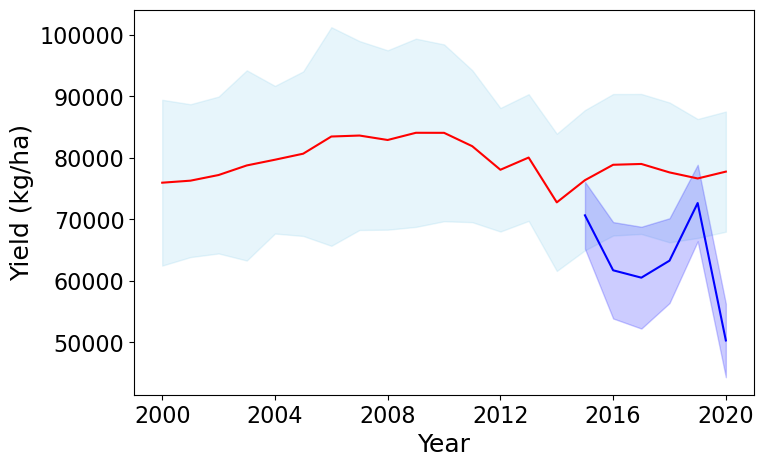

In [81]:
# Plots
plt.figure(figsize = (8,5))
plt.plot(new_data_by_year['Year'], new_data_by_year['Yield'], color = 'red', label='observed')
plt.fill_between(new_data_by_year['Year'], (new_data_by_year['Yield'] + new_data_by_year['st_yield']), 
                 (new_data_by_year['Yield'] - new_data_by_year['st_yield']), alpha = 0.2, color = 'skyblue')
plt.plot(new_pred_by_year_q['Year'], new_pred_by_year_q['Pred_yield'], color = 'blue', label = 'predicted')
plt.fill_between(new_pred_by_year_q['Year'], (new_pred_by_year_q['Pred_yield'] + new_pred_by_year_q['st_pred_yield']), 
                (new_pred_by_year_q['Pred_yield'] - new_pred_by_year_q['st_pred_yield']), alpha = 0.2, color = 'blue')
plt.ylabel('Yield (kg/ha)', fontsize = 18)
plt.tick_params(labelsize=16)
plt.xlabel('Year', fontsize = 18)
#plt.savefig("predicted_yield_over_time_quantiles.jpeg", dpi = 300)
plt.show()

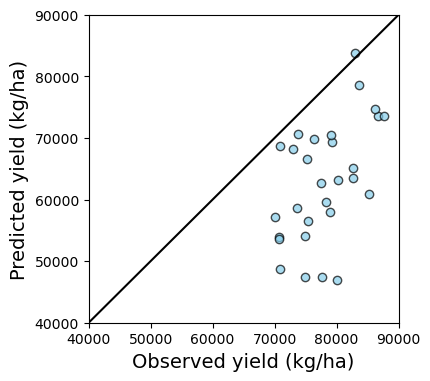

In [82]:
# Plot
fig, ax = plt.subplots(figsize=(4, 4))
ax = plt.gca()
ax.set_ylim([40000, 90000])
ax.set_xlim([40000, 90000])
ax.scatter(pred_yield_q['Yield'], pred_yield_q['Pred_yield'], edgecolor='k', facecolor='skyblue', alpha=0.7)
ax.axline((0, 1), slope=1, color='black', label='by slope')
ax.set_ylabel('Predicted yield (kg/ha)', fontsize=14)
ax.set_xlabel('Observed yield (kg/ha)', fontsize=14)
#plt.savefig('predicted_vs_observed_2015-2020_quantiles.jpeg', dpi = 300)
plt.show()

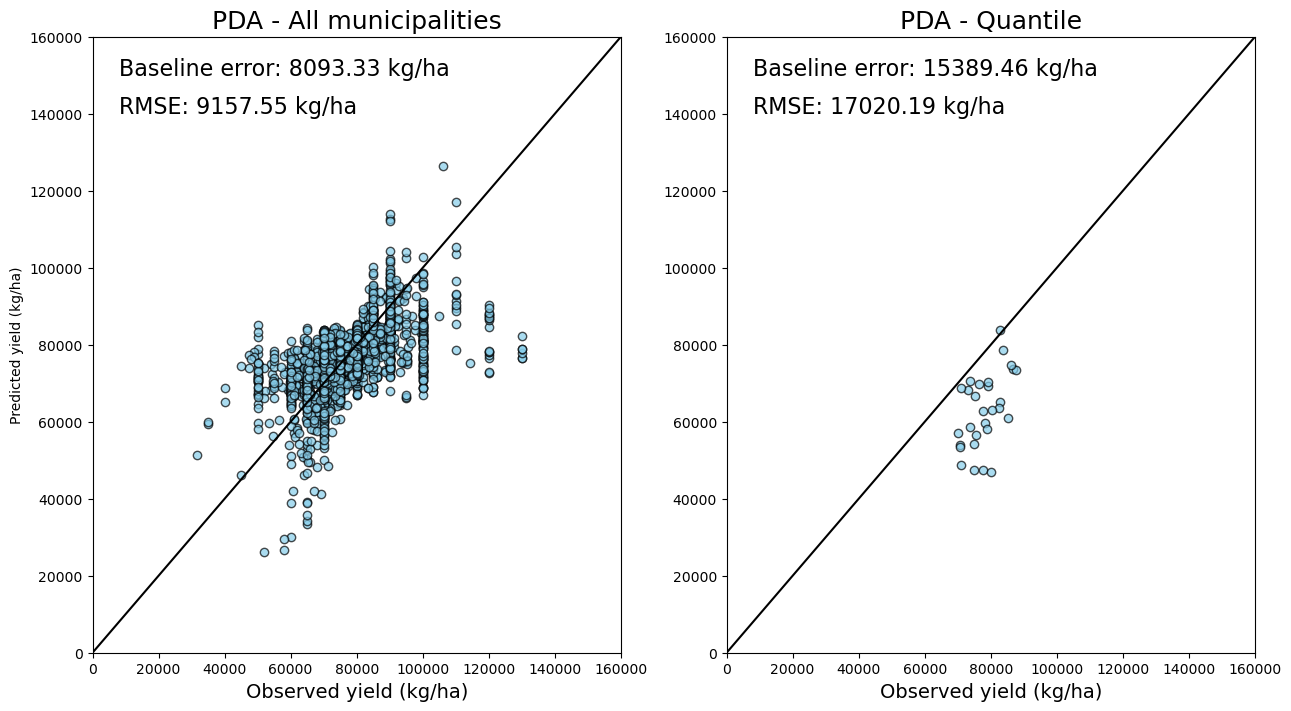

In [83]:
## Juntar as figuas
# Plot
plt.figure(figsize=(15, 8))


plt.subplot(1,2,1)
ax = plt.gca()
ax.set_ylim([0, 160000])
ax.set_xlim([0, 160000])
plt.scatter(pred_yield['Yield'], pred_yield['Predicted yield'], edgecolor='k', facecolor='skyblue', alpha=0.7)
ax.axline((0, 1), slope=1, color='black', label='by slope')
plt.text(8000, 150000, 'Baseline error: 8093.33 kg/ha', fontsize = 16)
plt.text(8000, 140000, 'RMSE: 9157.55 kg/ha', fontsize = 16)
plt.ylabel('')
plt.xlabel('Observed yield (kg/ha)', fontsize=14)
plt.ylabel('Predicted yield (kg/ha)')
plt.title('PDA - All municipalities', fontsize=18)

plt.subplot(1,2,2)
ax = plt.gca()
ax.set_ylim([0, 160000])
ax.set_xlim([0, 160000])
plt.scatter(pred_yield_q['Yield'], pred_yield_q['Pred_yield'], edgecolor='k', facecolor='skyblue', alpha=0.7)
ax.axline((0, 1), slope=1, color='black', label='by slope')
plt.text(8000, 150000, 'Baseline error: 15389.46 kg/ha', fontsize = 16)
plt.text(8000, 140000, 'RMSE: 17020.19 kg/ha', fontsize = 16)
plt.ylabel('')
plt.xlabel('Observed yield (kg/ha)', fontsize=14)
plt.title('PDA - Quantile', fontsize=18)

#plt.savefig('predicted_vs_observed_2015-2020_pda.jpeg', dpi = 300)
plt.show()

## Machine learning

In [4]:
# Remove NAs
data_sugarcane.dropna(subset = 'Yield', inplace = True)
data_sugarcane.head()

,CD_MUN,MUN,Year,Yield,AC,QP,VP,AET,NDVI,NPP,SOIL,TMIN,TMMX,PR,LST
0,3500105,Adamantina (SP),2000,50000.0,7000.0,350000.0,6244.0,704,5174.465583,4047,165.814275,163,288,91,15244
2,3500303,Aguaí (SP),2000,80000.0,5250.0,420000.0,7493.0,675,5613.906725,8672,398.974009,151,272,109,15133
4,3500709,Agudos (SP),2000,70000.0,8000.0,560000.0,9990.0,746,5968.640067,9080,247.830150,146,274,94,15097
6,3500907,Altair (SP),2000,75000.0,6000.0,450000.0,8028.0,686,5609.467113,5608,412.288194,168,297,107,15220
7,3501004,Altinópolis (SP),2000,70000.0,10000.0,700000.0,12488.0,681,5739.925326,8993,410.676864,154,268,123,15175


In [ ]:
Total: 486 municipios, anos 2000-2020, ano 2021
Treinamento 2000-2014, teste 2015-2020, ano 2021

In [5]:
# Split the dataset into X and Y -- Convert to z-score
x = data_sugarcane[['AC','QP','VP' ,'AET', 'SOIL', 'NDVI','TMIN', 'TMMX', 'PR', 'LST', 'NPP']]
y = data_sugarcane['Yield']

In [6]:
# Split dataset into training and validation
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 672, test_size = 0.30)

In [7]:
# Baseline errors, and display average baseline error
baseline_errors = abs(y_test.mean() - y_test)
print('Erro médio base: ', round(np.mean(baseline_errors), 2), 'kg/ha')

Erro médio base:  9569.7 kg/ha


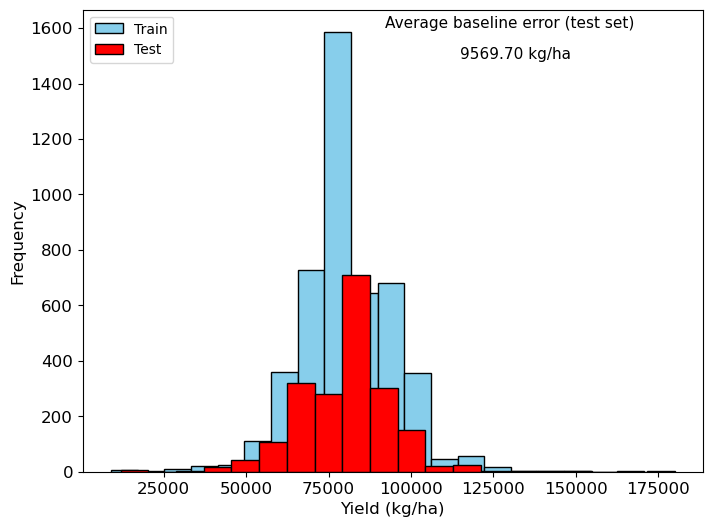

In [8]:
# Plot train and test datasets
plt.subplots(figsize=(8, 6))
plt.hist(y_train, bins = 20, ec = 'black', color = 'skyblue', label = 'Train')
plt.hist(y_test, bins = 20, ec = 'black', color ='red', label = 'Test')
plt.legend(loc='upper left')
plt.xlabel('Yield (kg/ha)', fontsize = 12)
plt.tick_params(labelsize=12)
plt.ylabel('Frequency', fontsize = 12)
plt.text(92000, 1600, 'Average baseline error (test set)', fontsize = 11)
plt.text(115000, 1490, '9569.70 kg/ha', fontsize = 11)
#plt.savefig("hist_train_test.jpeg", dpi = 300)
plt.show()

In [9]:
# Gradient Boosting - Modelo base, sem tuning de parâmetros
base_gb = GradientBoostingRegressor().fit(x_train, y_train)
print('O R-squared do treinamento é: {}'.format(round(base_gb.score(x_train, y_train), 2)))
print('O R-squared do teste é: {}'.format(round(base_gb.score(x_test, y_test), 2)))

O R-squared do treinamento é: 0.7
O R-squared do teste é: 0.6


In [10]:
# Random Forest - Modelo base, sem tuning de parâmetros
base_rf = RandomForestRegressor().fit(x_train, y_train)
print('O R-squared do treinamento é: {}'.format(round(base_rf.score(x_train, y_train), 2)))
print('O R-squared do teste é:  {}'.format(round(base_rf.score(x_test, y_test), 2)))

O R-squared do treinamento é: 0.95
O R-squared do teste é:  0.65


In [54]:
# Predição para GB e RF
base_pred_gb = base_gb.predict(x_test)
base_pred_rf = base_rf.predict(x_test)

rmse_gb = float(format(np.sqrt(mean_squared_error(y_test, base_pred_gb)), '.2f'))
rmse_rf = float(format(np.sqrt(mean_squared_error(y_test, base_pred_rf)), '.2f'))

print ('\nPerformances')
print('RMSE Gradient Boosting = ', rmse_gb, 'kg/ha')
print('RMSE Random Forest = ', rmse_rf, 'kg/ha')


Performances
RMSE Gradient Boosting =  8765.53 kg/ha
RMSE Random Forest =  8246.33 kg/ha


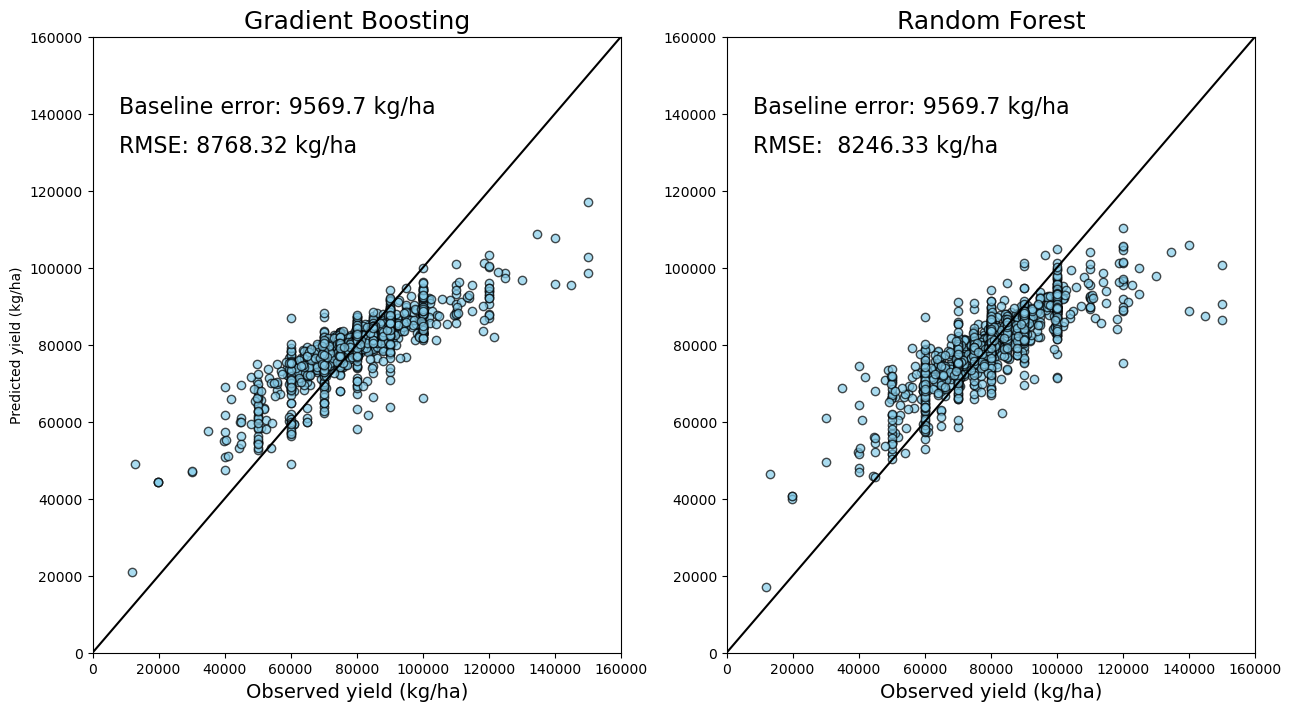

In [55]:
# Plot
plt.figure(figsize=(15, 8))

plt.subplot(1,2,1)
ax = plt.gca()
ax.set_ylim([0, 160000])
ax.set_xlim([0, 160000])
plt.scatter(y_test, base_pred_gb, edgecolor='k', facecolor='skyblue', alpha=0.7)
ax.axline((0, 1), slope=1, color='black', label='by slope')
plt.text(8000, 140000, 'Baseline error: 9569.7 kg/ha', fontsize = 16)
plt.text(8000, 130000, 'RMSE: 8768.32 kg/ha', fontsize = 16)
plt.ylabel('')
plt.xlabel('Observed yield (kg/ha)', fontsize=14)
plt.ylabel('Predicted yield (kg/ha)')
plt.title('Gradient Boosting', fontsize=18)

plt.subplot(1,2,2)
ax = plt.gca()
ax.set_ylim([0, 160000])
ax.set_xlim([0, 160000])
ax.axline((0, 1), slope=1, color='black', label='by slope')
plt.scatter(y_test, base_pred_rf, edgecolor='k', facecolor='skyblue', alpha=0.7)
plt.text(8000, 140000, 'Baseline error: 9569.7 kg/ha', fontsize = 16)
plt.text(8000, 130000, 'RMSE:  8246.33 kg/ha', fontsize = 16)
plt.ylabel('')
plt.xlabel('Observed yield (kg/ha)', fontsize=14)
r2_lr = 0.77
plt.title('Random Forest', fontsize=18)

#plt.savefig('predicted_vs_observed_2015-2020_gb_rf.jpeg', dpi = 300)
plt.show()

### Hyperparameter tuning  -- Gradient Boosting

In [ ]:
y = a+bx
a=intercepto
b=slope

In [13]:
# Parameters of base models
print('\nParameters em uso no Gradient Boosting:\n')
pprint(base_gb.get_params())


Parameters em uso no Gradient Boosting:

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [14]:
# Number of trees
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

# Loss
loss = ['squared_error', 'absolute_error', 'huber']

# Learning rate
learning_rate = [0.05, 0.1, 0.2, 0.5]

# Samples split
min_samples_split = [2, 4, 8, 12, 20, 50, 80]

# Samples leaf
min_samples_leaf = [2, 4, 6, 8, 10, 20, 30, 50, 100]

# Depth
max_depth = [2, 4, 6, 8, 12, 15, 20]

# Max features
max_features = ['auto', 'sqrt', 'log2']

# Max nodes
max_leaf_nodes = [2, 6, 10, 15, 20]

# Create the random grid
random_search_gb = {'n_estimators': n_estimators,
                    'loss': loss,
                    'learning_rate': learning_rate,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'max_depth': max_depth,
                    'max_leaf_nodes': max_leaf_nodes,
                    'max_features': max_features}
random_search_gb

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'loss': ['squared_error', 'absolute_error', 'huber'],
 'learning_rate': [0.05, 0.1, 0.2, 0.5],
 'min_samples_split': [2, 4, 8, 12, 20, 50, 80],
 'min_samples_leaf': [2, 4, 6, 8, 10, 20, 30, 50, 100],
 'max_depth': [2, 4, 6, 8, 12, 15, 20],
 'max_leaf_nodes': [2, 6, 10, 15, 20],
 'max_features': ['auto', 'sqrt', 'log2']}

In [15]:
## Rodar o random search
gb_tuning = GradientBoostingRegressor()

gb_tuning_RSCV = RandomizedSearchCV(estimator = gb_tuning, 
                                    param_distributions = random_search_gb, 
                                    n_iter = 10, 
                                    cv = 10, 
                                    verbose = 2, 
                                    n_jobs = -1)

gb_tuning_RSCV.fit(x_train, y_train)

## Print the best parameters
print('\nThe best parameters are: \n')
pprint(gb_tuning_RSCV.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits

The best parameters are: 

{'learning_rate': 0.5,
 'loss': 'absolute_error',
 'max_depth': 6,
 'max_features': 'auto',
 'max_leaf_nodes': 15,
 'min_samples_leaf': 8,
 'min_samples_split': 8,
 'n_estimators': 300}


In [33]:
## Usando o GridSearch
gb_grid_params = {'learning_rate': [0.1,0.2], 
                  'loss': ['huber', 'squared_error'], 
                  'n_estimators': [500, 1000],
                  'min_samples_split': [8, 10], 
                  'min_samples_leaf': [8, 10], 
                  'max_features': ['auto'], 
                  'max_depth': [20, 50],
                  'max_leaf_nodes': [6,8,10]}

gb_grid = GradientBoostingRegressor()
grid_search_gb = GridSearchCV(estimator = gb_grid, 
                           param_grid = gb_grid_params, 
                           cv = 10, 
                           n_jobs = -1, 
                           verbose = 2)

In [34]:
# Fit grid search
grid_search_gb.fit(x_train, y_train)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


GridSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2],
                         'loss': ['huber', 'squared_error'],
                         'max_depth': [20, 50], 'max_features': ['auto'],
                         'max_leaf_nodes': [6, 8, 10],
                         'min_samples_leaf': [8, 10],
                         'min_samples_split': [8, 10],
                         'n_estimators': [500, 1000]},
             verbose=2)

In [35]:
# Best parameters
grid_search_gb.best_params_

{'learning_rate': 0.2,
 'loss': 'squared_error',
 'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': 6,
 'min_samples_leaf': 10,
 'min_samples_split': 8,
 'n_estimators': 1000}

In [36]:
best_grid_gb = grid_search_gb.best_estimator_

In [37]:
# Predict onto the test set
pred_grid_gb = best_grid_gb.predict(x_test)

In [38]:
# Scores
rmse_gb = float(format(np.sqrt(mean_squared_error(y_test, pred_grid_gb)), '.3f'))
print ('\nPerformance')
print('RMSE = ', rmse_gb, 'g/kg')

print('R2 = {}'.format(round(best_grid_gb.score(x_test, y_test), 2)))


Performance
RMSE =  3213.775 g/kg
R2 = 0.95


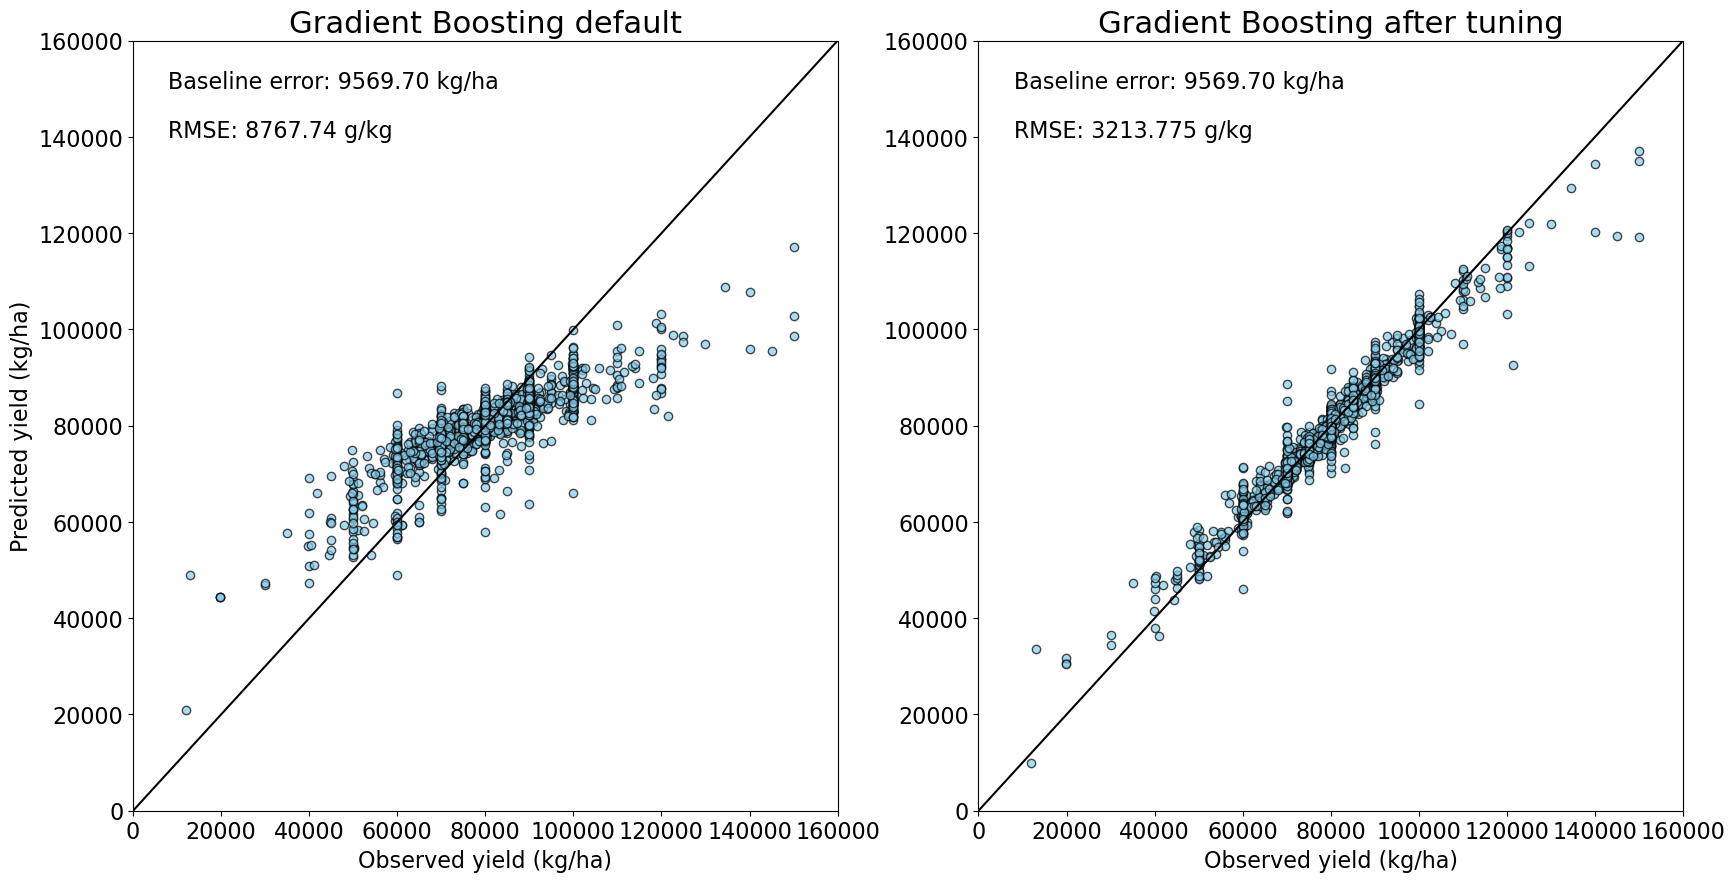

In [56]:
# Plot observed vs predicted
# Plot
plt.figure(figsize=(20, 10))

plt.subplot(1,2,1)
ax = plt.gca()
ax.set_ylim([0, 160000])
ax.set_xlim([0, 160000])
plt.scatter(y_test, base_pred_gb, edgecolor='k', facecolor='skyblue', alpha=0.7)
ax.axline((0, 1), slope=1, color='black', label='by slope')
plt.text(8000, 150000 , 'Baseline error: 9569.70 kg/ha', fontsize = 16)
plt.text(8000, 140000,  'RMSE: 8767.74 g/kg', fontsize = 16)
plt.tick_params(labelsize=16)
plt.xlabel('Observed yield (kg/ha)', fontsize=16)
plt.ylabel('Predicted yield (kg/ha)', fontsize=16)
plt.title('Gradient Boosting default', fontsize=22)

plt.subplot(1,2,2)
ax = plt.gca()
ax.set_ylim([0, 160000])
ax.set_xlim([0, 160000])
plt.scatter(y_test, pred_grid_gb, edgecolor='k', facecolor='skyblue', alpha=0.7)
ax.axline((0, 1), slope=1, color='black', label='by slope')
plt.text(8000, 150000, 'Baseline error: 9569.70 kg/ha', fontsize = 16)
plt.text(8000, 140000, 'RMSE: 3213.775 g/kg', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylabel('')
plt.xlabel('Observed yield (kg/ha)', fontsize=16)
plt.title('Gradient Boosting after tuning', fontsize=22)
#plt.savefig('pred_vs_obs_2015-2020_gb_default_params.jpeg', dpi = 400)
plt.show()

### Importância das variáveis

In [31]:
# Get numerical feature importances
importance = list(best_grid_gb.feature_importances_)
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(x_train.columns, importance)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: QP                   Importance: 0.47
Variable: AC                   Importance: 0.404
Variable: NPP                  Importance: 0.034
Variable: VP                   Importance: 0.021
Variable: AET                  Importance: 0.018
Variable: PR                   Importance: 0.012
Variable: TMIN                 Importance: 0.011
Variable: LST                  Importance: 0.01
Variable: TMMX                 Importance: 0.009
Variable: SOIL                 Importance: 0.007
Variable: NDVI                 Importance: 0.004


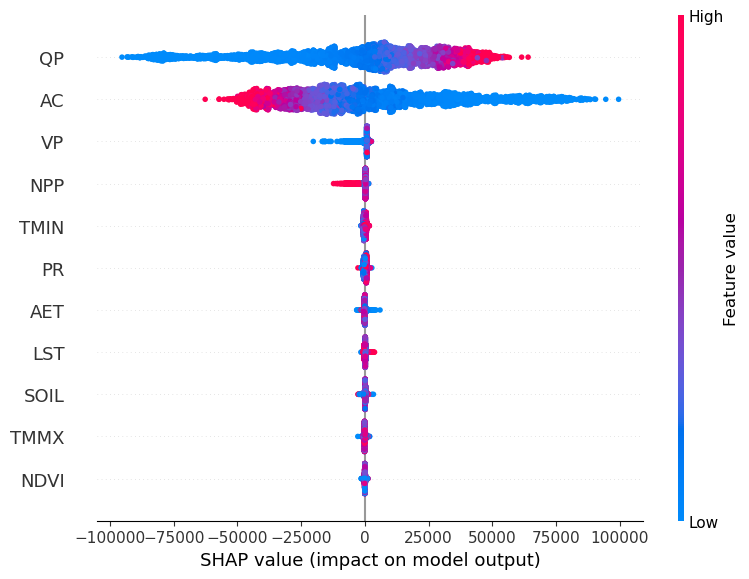

In [32]:
import shap
## Shapley values to explain RF models
explainer = shap.TreeExplainer(best_grid_gb)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, features = x_train, feature_names = x_train.columns)

### Predição para os anos 2015 - 2020 -- Validação

In [57]:
# Carregar os dados e separar o x do y
dat_2015_2020 = pd.read_csv("tables/dados_all_2015-2020.csv", sep = ';')
dat_2015_2020.dropna(inplace = True)
x_val = dat_2015_2020[['AC','QP','VP' ,'AET', 'SOIL', 'NDVI','TMIN', 'TMMX', 'PR', 'LST', 'NPP']]
y_val = dat_2015_2020['Yield']

In [58]:
x_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2872 entries, 0 to 2909
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AC      2872 non-null   float64
 1   QP      2872 non-null   float64
 2   VP      2872 non-null   float64
 3   AET     2872 non-null   int64  
 4   SOIL    2872 non-null   float64
 5   NDVI    2872 non-null   float64
 6   TMIN    2872 non-null   int64  
 7   TMMX    2872 non-null   int64  
 8   PR      2872 non-null   int64  
 9   LST     2872 non-null   int64  
 10  NPP     2872 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 269.2 KB


In [60]:
# Predezir no conjunto de validação e adicionar ao df do yield
dat_2015_2020['Pred_yieldGB'] = pd.DataFrame(best_grid_gb.predict(x_val))
dat_2015_2020.head()

,ID,CD_MUN,MUN,Year,Yield,AP,AC,QP,VP,AET,NDVI,NPP,SOIL,TMIN,TMMX,PR,LST,Pred_yieldGB
0,1,3500105,Adamantina (SP),2015,80000.0,12950.0,12950.0,1036000.0,61756.0,868,6270.276565,7688,308.184230,169,294,133,15178,79095.482833
1,2,3500204,Adolfo (SP),2015,70000.0,6309.0,6309.0,441630.0,23680.0,885,5062.510928,7706,368.446534,167,295,132,15046,70975.339002
2,3,3500303,Aguaí (SP),2015,80000.0,12500.0,12500.0,1000000.0,53530.0,820,6468.525723,8977,477.758122,158,280,138,15127,80263.205685
3,4,3500550,Águas de Santa Bárbara (SP),2015,90000.0,5500.0,5500.0,495000.0,29700.0,886,6688.432525,10815,401.884688,148,277,138,15030,91323.826143
4,5,3500709,Agudos (SP),2015,64794.0,14632.0,14632.0,948062.0,37069.0,874,7096.525518,10763,349.336278,152,280,134,15013,65874.211763


In [61]:
# Carregar os dados preditos para os outros anos
pred_yield = pd.read_csv('predictions/predicted_2015-2020_GB.csv', sep = ';').drop(['ID'], axis = 1)
pred_yield.head()

,CD_MUN,MUN,Year,Yield,Pred_yieldGB
0,3500105,Adamantina (SP),2015,80000,79842
1,3500204,Adolfo (SP),2015,70000,70007
2,3500303,Aguaí (SP),2015,80000,80042
3,3500550,Águas de Santa Bárbara (SP),2015,90000,90685
4,3500709,Agudos (SP),2015,64794,64761


In [62]:
# Agrupar por ano e calcular o desvio padrão
predGB_by_year = pd.DataFrame(pred_yield.groupby('Year')['Pred_yieldGB'].mean().reset_index())
predGB_by_year['Pred_yieldGB'] = predGB_by_year['Pred_yieldGB'].astype(int)
st_predGB_yield = pd.DataFrame(pred_yield.groupby('Year')['Pred_yieldGB'].std()).reset_index()
st_predGB_yield.rename(columns = {'Pred_yieldGB': 'st_predGB_yield'}, inplace = True)
st_predGB_yield['st_predGB_yield'] = st_predGB_yield['st_predGB_yield'].astype(int)
new_predGB_by_year = predGB_by_year.join([st_predGB_yield['st_predGB_yield']])
new_predGB_by_year = new_predGB_by_year.astype(int)
new_predGB_by_year['Year'] = pd.to_datetime(new_predGB_by_year['Year'], format = '%Y')
new_predGB_by_year

,Year,Pred_yieldGB,st_predGB_yield
0,2015-01-01,77001,9892
1,2016-01-01,78935,9780
2,2017-01-01,79038,9769
3,2018-01-01,77627,9846
4,2019-01-01,76999,8598
5,2020-01-01,78795,9035


In [63]:
# Plots
## Carregar os dados de todos os anos
obs_yield = pd.read_csv("tables/dat_yield_melt_all_years.csv").drop(['Unnamed: 0'], axis = 1)
obs_yield.rename(columns = {'variable': 'Year', 'value': 'Yield'}, inplace = True)
new_by_year = pd.DataFrame(obs_yield.groupby('Year')['Yield'].mean().reset_index())
new_by_year['Yield'] = new_by_year['Yield'].astype(int)
st_yield = pd.DataFrame(obs_yield.groupby('Year')['Yield'].std()).reset_index()
st_yield.rename(columns = {'Yield': 'st_yield'}, inplace = True)
st_yield['st_yield'] = st_yield['st_yield'].astype(int)
new_data_by_year = new_by_year.join([st_yield['st_yield']])
new_data_by_year = new_data_by_year.astype(int)
new_data_by_year['Year'] = pd.to_datetime(new_data_by_year['Year'], format = '%Y')
new_data_by_year

,Year,Yield,st_yield
0,2000-01-01,75980,13483
1,2001-01-01,76309,12431
2,2002-01-01,77228,12757
3,2003-01-01,78786,15468
4,2004-01-01,79715,12006
5,2005-01-01,80696,13380
6,2006-01-01,83491,17777
7,2007-01-01,83649,15362
8,2008-01-01,82926,14588
9,2009-01-01,84098,15308


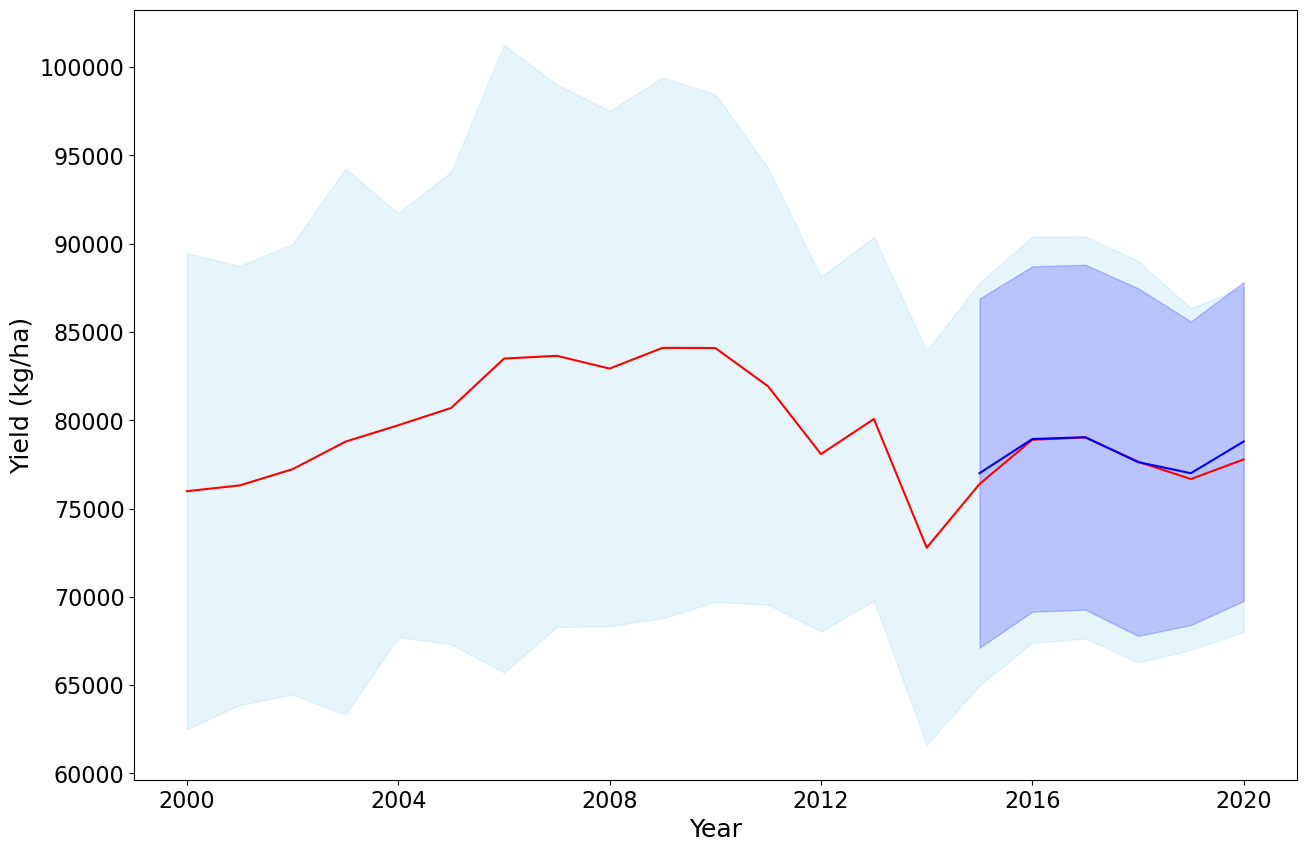

In [47]:
# Plots
plt.figure(figsize = (15,10))
plt.plot(new_data_by_year['Year'], new_data_by_year['Yield'], color = 'red', label='observed')
plt.fill_between(new_data_by_year['Year'], (new_data_by_year['Yield'] + new_data_by_year['st_yield']), 
                 (new_data_by_year['Yield'] - new_data_by_year['st_yield']), alpha = 0.2, color = 'skyblue')
plt.plot(new_predGB_by_year['Year'], new_predGB_by_year['Pred_yieldGB'], color = 'blue', label = 'predicted')
plt.fill_between(new_predGB_by_year['Year'], (new_predGB_by_year['Pred_yieldGB'] + new_predGB_by_year['st_predGB_yield']), 
                (new_predGB_by_year['Pred_yieldGB'] - new_predGB_by_year['st_predGB_yield']), alpha = 0.2, color = 'blue')
plt.ylabel('Yield (kg/ha)', fontsize = 18)
plt.tick_params(labelsize=16)
plt.xlabel('Year', fontsize = 18)
#plt.savefig("predicted_yieldGB_over_time.jpeg", dpi = 300)
plt.show()

### Predição para o ano de 2021

In [48]:
# Carregar os dados e separar o x do y
dat_2021= pd.read_csv("tables/aal_data_clean_2021.csv",sep = ';')
x_2021 = dat_2021[['AC','QP','VP' ,'aet_2021', 'soil_2021', 'NDVI_2021','tminx_2021', 'tmmx_2021', 'pr_2021', 'LST_2021', 'npp_2021']]

In [49]:
# Predezir no conjunto de validação e adicionar ao df do yield
pred_gb_2021 = pd.DataFrame(best_grid_gb.predict(x_2021).round(0))

In [50]:
preds_2021 = pd.read_csv("predictions/predicted_2021.csv", sep = ';')
preds_2021['Pred_yieldGB_2021'] = pred_gb_2021
preds_2021.to_csv("preds_2021_PDA_GB.csv", index = False)

In [51]:
preds_2021.dropna(inplace = True)
preds_2021.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514 entries, 0 to 514
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CD_MUN               514 non-null    int64  
 1   NM_MUN               514 non-null    object 
 2   Yield                514 non-null    int64  
 3   Pred_yield_PDA_calc  514 non-null    float64
 4   Pred_yieldGB_2021    514 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 24.1+ KB


In [52]:
# Scores
rmse_pda_2021 = float(format(np.sqrt(mean_squared_error(preds_2021['Yield'], preds_2021['Pred_yield_PDA_calc'])), '.2f'))
print ('\nPerformance')
print('RMSE PDA 2021 = ', rmse_pda_2021, 'g/kg')

rmse_gb_2021 = float(format(np.sqrt(mean_squared_error(preds_2021['Yield'], preds_2021['Pred_yieldGB_2021'])), '.2f'))
print ('\nPerformance')
print('RMSE GB 2021 = ', rmse_gb_2021, 'g/kg')


Performance
RMSE PDA 2021 =  11663.29 g/kg

Performance
RMSE GB 2021 =  6098.76 g/kg


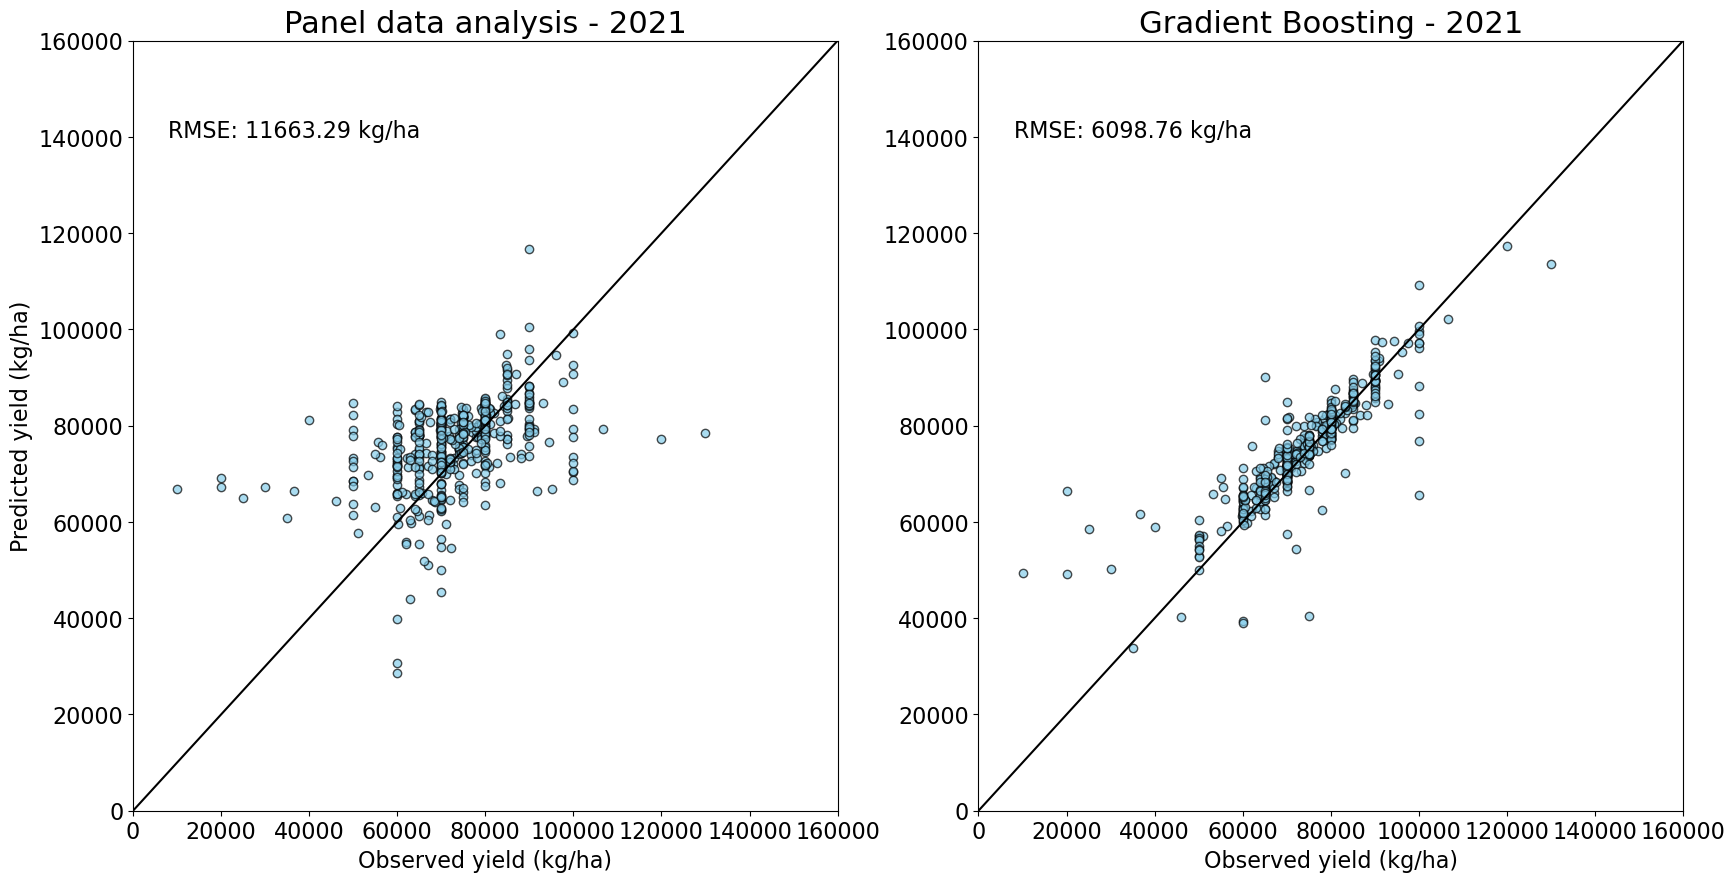

In [64]:
# Plot observed vs predicted
# Plot
plt.figure(figsize=(20, 10))

plt.subplot(1,2,1)
ax = plt.gca()
ax.set_ylim([0, 160000])
ax.set_xlim([0, 160000])
plt.scatter(preds_2021['Yield'], preds_2021['Pred_yield_PDA_calc'], edgecolor='k', facecolor='skyblue', alpha=0.7)
ax.axline((0, 1), slope=1, color='black', label='by slope')
plt.text(8000, 140000,  'RMSE: 11663.29 kg/ha', fontsize = 16)
plt.tick_params(labelsize=16)
plt.xlabel('Observed yield (kg/ha)', fontsize=16)
plt.ylabel('Predicted yield (kg/ha)', fontsize=16)
plt.title('Panel data analysis - 2021', fontsize=22)

plt.subplot(1,2,2)
ax = plt.gca()
ax.set_ylim([0, 160000])
ax.set_xlim([0, 160000])
plt.scatter(preds_2021['Yield'], preds_2021['Pred_yieldGB_2021'], edgecolor='k', facecolor='skyblue', alpha=0.7)
ax.axline((0, 1), slope=1, color='black', label='by slope')
plt.text(8000, 140000,  'RMSE: 6098.76 kg/ha', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylabel('')
plt.xlabel('Observed yield (kg/ha)', fontsize=16)
plt.title('Gradient Boosting - 2021', fontsize=22)
plt.savefig('pred_vs_obs_2021_gb_pda.jpeg', dpi = 400)
plt.show()

### Hyperparameter tuning - Random Forest

In [43]:
# Parameters of base models
print('\nParameters currently in use in RF:\n')
pprint(base_rf.get_params())


Parameters currently in use in RF:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [65]:
# Number of trees
n_estimators = [10, 20, 50, 10]

# Bootstraping
boostrap = ['True', 'False']

# Depth
max_depth = [2, 4, 6, 8, 12, 15, 20]

# Max features
max_features = ['sqrt', 'log2']

# Max nodes
max_leaf_nodes = [2, 6, 10, 15, 20]

# Max samples
max_samples = [10, 20, 40, 60]

# Samples leaf
min_samples_leaf = [2, 4, 6, 8, 10, 20, 30, 50, 100]

# Samples split
min_samples_split = [2, 4, 8, 12, 20, 50, 80]


# Create the random grid
random_search_rf = {'n_estimators': n_estimators,
                    'bootstrap': boostrap,
                    'max_depth': max_depth,
                    'max_features': max_features,
                    'max_leaf_nodes': max_leaf_nodes,
                    'max_samples': max_samples,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf}
random_search_rf

{'n_estimators': [10, 20, 50, 10],
 'bootstrap': ['True', 'False'],
 'max_depth': [2, 4, 6, 8, 12, 15, 20],
 'max_features': ['sqrt', 'log2'],
 'max_leaf_nodes': [2, 6, 10, 15, 20],
 'max_samples': [10, 20, 40, 60],
 'min_samples_split': [2, 4, 8, 12, 20, 50, 80],
 'min_samples_leaf': [2, 4, 6, 8, 10, 20, 30, 50, 100]}

In [66]:
## Run the model with the hyperparameter tuning
rf_tuning = RandomForestRegressor()

rf_tuning_RSCV = RandomizedSearchCV(estimator = rf_tuning, 
                                    param_distributions = random_search_rf, 
                                    n_iter = 10, 
                                    cv = 10, 
                                    verbose = 2, 
                                    n_jobs = -1)

rf_tuning_RSCV.fit(x_train, y_train)

## Print the best parameters
print('\nThe best parameters are: \n')
pprint(rf_tuning_RSCV.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits

The best parameters are: 

{'bootstrap': 'True',
 'max_depth': 12,
 'max_features': 'log2',
 'max_leaf_nodes': 20,
 'max_samples': 60,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 10}


In [80]:
## Set cross-validation parameters
rf_grid_params = {'bootstrap' : ['True'], 
                  'n_estimators': [100],
                  'min_samples_split': [2], 
                  'min_samples_leaf': [1], 
                  'max_features': [1]}

rf_grid = RandomForestRegressor()
grid_search_rf = GridSearchCV(estimator = rf_grid, 
                           param_grid = rf_grid_params, 
                           cv = 10, 
                           n_jobs = -1, 
                           verbose = 2)

In [81]:
# Fit grid search
grid_search_rf.fit(x_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': ['True'], 'max_features': [1],
                         'min_samples_leaf': [1], 'min_samples_split': [2],
                         'n_estimators': [100]},
             verbose=2)

In [82]:
# Best parameters
grid_search_rf.best_params_

{'bootstrap': 'True',
 'max_features': 1,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [83]:
best_grid_rf = grid_search_rf.best_estimator_
rf_grid_acc = eval_model(best_grid_rf, best_grid_rf, x_test, y_test)
rf_grid_acc


Performances
RMSE Gradient Boosting =  11449.97 g/kg
RMSE Random Forest =  11449.97 g/kg


In [85]:
# Predict onto the test set
pred_grid_rf = best_grid_rf.predict(x_test)

array([76491.33, 83179.91, 79707.33, ..., 83658.36, 74764.67, 82340.24])

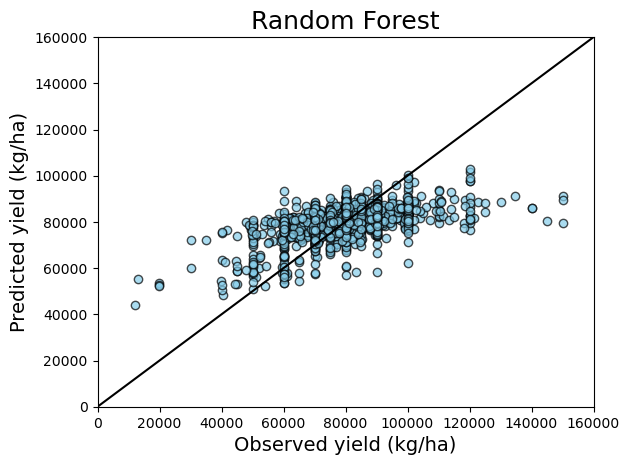

In [86]:
# Plot observed vs predicted
ax = plt.gca()
ax.set_ylim([0, 160000])
ax.set_xlim([0, 160000])
plt.scatter(y_test, pred_grid_rf, edgecolor='k', facecolor='skyblue', alpha=0.7)
ax.axline((0, 1), slope=1, color='black', label='by slope')
plt.ylabel('')
plt.xlabel('Observed yield (kg/ha)', fontsize=14)
plt.ylabel('Predicted yield (kg/ha)', fontsize=14)
plt.title('Random Forest', fontsize=18)
plt.show()

In [87]:
# Get numerical feature importances
importance = list(base_rf.feature_importances_)
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(x_train.columns, importance)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: QP                   Importance: 0.294
Variable: AC                   Importance: 0.234
Variable: NPP                  Importance: 0.073
Variable: AET                  Importance: 0.065
Variable: VP                   Importance: 0.058
Variable: NDVI                 Importance: 0.056
Variable: SOIL                 Importance: 0.055
Variable: LST                  Importance: 0.05
Variable: PR                   Importance: 0.046
Variable: TMIN                 Importance: 0.035
Variable: TMMX                 Importance: 0.035


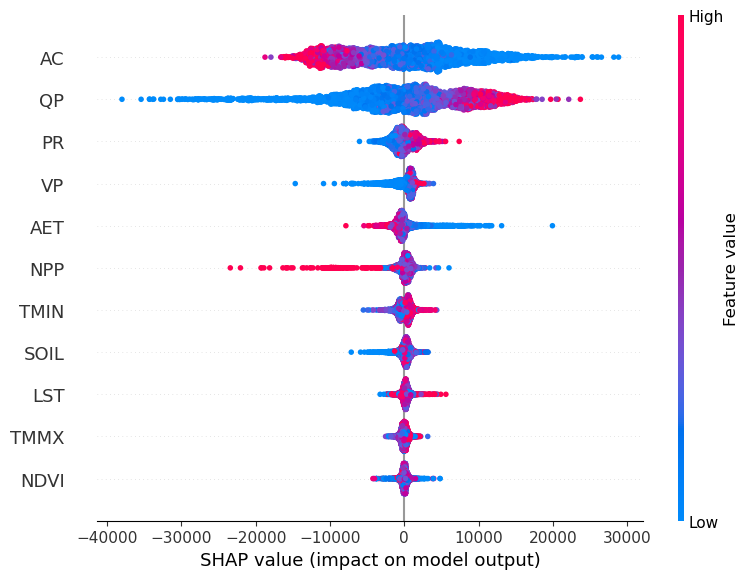

In [88]:
import shap
## Shapley values to explain RF models
explainer_rf = shap.TreeExplainer(base_rf)
shap_values_rf = explainer_rf.shap_values(x_train)
shap.summary_plot(shap_values_rf, features = x_train, feature_names = x_train.columns)

In [89]:
## Plot the contribution of an individual observation. In this case, the number 17
display(x_train.iloc[2])
shap.initjs()
i = 4
shap.force_plot(explainer_rf.expected_value, shap_values_rf[i], features=x_train.loc[i], feature_names=x_train.columns, plot_cmap="PkYg")

AC        5000.000000
QP      400000.000000
VP       20000.000000
AET        772.000000
SOIL       246.028158
NDVI      5838.393885
TMIN       156.000000
TMMX       283.000000
PR          98.000000
LST      15175.000000
NPP       7828.000000
Name: 6191, dtype: float64

In [ ]:
## End